In [27]:
import pandas as pd
from src.utils.path_converter import path_converter

In [28]:
df = pd.read_csv(path_converter("/data/raw/sales_train.csv"), encoding="latin1")

In [29]:
# # Load dữ liệu
# df2 = pd.read_csv(path_converter("/data/raw/online_retail.csv"), encoding="latin1")

# # Chuyển InvoiceDate sang datetime
# df2["InvoiceDate"] = pd.to_datetime(df2["InvoiceDate"], dayfirst=True)

# # Thêm date_block_num theo tháng
# df2["date_block_num"] = (df2["InvoiceDate"].dt.year - 2010) * 12 + (
#     df2["InvoiceDate"].dt.month - 1
# )

# # Nếu chỉ có 1 shop: tạo shop_id = 0
# df2["shop_id"] = 0

# # Map StockCode thành item_id
# df2["item_id"] = df2["StockCode"].astype("category").cat.codes

# # Group theo ngày + item + shop
# df2_new = (
#     df2.groupby(["InvoiceDate", "date_block_num", "shop_id", "item_id"])
#     .agg(
#         {"UnitPrice": "mean", "Quantity": "sum"}  # trung bình nếu nhiều đơn trong ngày
#     )
#     .reset_index()
# )

# # Đổi tên cột và chuyển date về format DD.MM.YYYY
# df2_new.rename(
#     columns={
#         "InvoiceDate": "date",
#         "UnitPrice": "item_price",
#         "Quantity": "item_cnt_day",
#     },
#     inplace=True,
# )

# df2_new["date"] = df2_new["date"].dt.strftime("%d.%m.%Y")

# df = df2_new.copy()

# print(df2_new.head())

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [31]:
total_cnt_day = df['item_cnt_day'].sum()
print(total_cnt_day)

3648206.0


In [32]:
block_cnt = df['item_cnt_day'].groupby(df['date_block_num']).sum()

In [33]:
total_cnt = block_cnt.sum()

In [34]:
sold = df[df['item_cnt_day'] >= 0]
return_goods = df[df['item_cnt_day'] < 0]

In [35]:
print(sold['item_cnt_day'].sum())
print(return_goods['item_cnt_day'].sum())

3655747.0
-7541.0


In [36]:
unique_date_per_block_num = df['date'].groupby(df['date_block_num']).nunique()
print(unique_date_per_block_num)

date_block_num
0     31
1     28
2     31
3     30
4     31
5     30
6     31
7     31
8     30
9     31
10    30
11    31
12    31
13    28
14    31
15    30
16    31
17    30
18    31
19    31
20    30
21    31
22    30
23    31
24    31
25    28
26    31
27    30
28    31
29    30
30    31
31    31
32    30
33    31
Name: date, dtype: int64


ta thấy block nào cũng đủ date trong tháng -> có thể tính tổng days = nunique cột date

In [37]:
total_days_of_selling = unique_date_per_block_num.sum()

print(total_days_of_selling)

1034


In [38]:
non_zero_demand_days = df['date'].groupby(sold['item_id']).nunique()

zero_demand_days = total_days_of_selling - non_zero_demand_days

zero_ratio = zero_demand_days / total_days_of_selling

print(non_zero_demand_days)
print(zero_demand_days)
print(zero_ratio)

item_id
0.0          1
1.0          6
2.0          2
3.0          2
4.0          1
          ... 
22165.0      2
22166.0    270
22167.0    570
22168.0      6
22169.0      1
Name: date, Length: 21804, dtype: int64
item_id
0.0        1033
1.0        1028
2.0        1032
3.0        1032
4.0        1033
           ... 
22165.0    1032
22166.0     764
22167.0     464
22168.0    1028
22169.0    1033
Name: date, Length: 21804, dtype: int64
item_id
0.0        0.999033
1.0        0.994197
2.0        0.998066
3.0        0.998066
4.0        0.999033
             ...   
22165.0    0.998066
22166.0    0.738878
22167.0    0.448743
22168.0    0.994197
22169.0    0.999033
Name: date, Length: 21804, dtype: float64


đếm tổng string khác nhau của 1 loại item => số ngày mà sản phẩm đó được bán

In [39]:
print(non_zero_demand_days.describe())

count    21804.000000
mean        70.559989
std        109.182634
min          1.000000
25%          6.000000
50%         29.000000
75%         86.000000
max       1033.000000
Name: date, dtype: float64


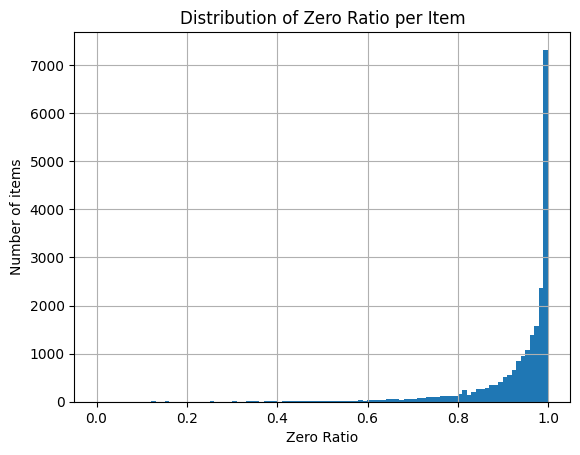

count    21804.000000
mean         0.931760
std          0.105592
min          0.000967
25%          0.916828
50%          0.971954
75%          0.994197
max          0.999033
Name: date, dtype: float64


In [40]:
zero_ratio.hist(bins=100)
plt.xlabel('Zero Ratio')
plt.ylabel('Number of items')
plt.title('Distribution of Zero Ratio per Item')
plt.show()
print(zero_ratio.describe())

In [41]:
day_sell_of_item = df['date'].groupby(sold['item_id']).unique()

In [42]:
items_df = pd.concat([zero_ratio, day_sell_of_item], axis=1)
items_df.columns = ['zero_ratio', 'days_sold']
print(items_df)

         zero_ratio                                          days_sold
item_id                                                               
0.0        0.999033                                       [01.09.2014]
1.0        0.994197  [04.04.2014, 02.04.2014, 06.07.2014, 04.08.201...
2.0        0.998066                           [24.08.2014, 12.11.2014]
3.0        0.998066                           [05.07.2014, 26.08.2014]
4.0        0.999033                                       [19.09.2014]
...             ...                                                ...
22165.0    0.998066                           [26.08.2013, 18.05.2014]
22166.0    0.738878  [31.10.2013, 30.10.2013, 27.10.2013, 26.10.201...
22167.0    0.448743  [29.09.2013, 28.09.2013, 30.09.2013, 27.09.201...
22168.0    0.994197  [20.01.2013, 15.01.2013, 02.02.2013, 17.02.201...
22169.0    0.999033                                       [21.03.2014]

[21804 rows x 2 columns]


In [43]:
from src.utils.date_caculator import compute_interarrival
items_df['interarrival'] = items_df['days_sold'].map(compute_interarrival)


In [44]:
items_df['var_demand_days'] = sold['item_cnt_day'].groupby(sold['item_id']).var()
items_df['mean_demand_days'] = sold['item_cnt_day'].groupby(sold['item_id']).mean()
items_df['cv2'] = items_df['var_demand_days'] / (items_df['mean_demand_days'] ** 2)


In [45]:
items_df['ADI'] = items_df['interarrival'].apply(np.mean)

print(items_df['ADI'].describe())

count    19421.000000
mean        26.773195
std         57.460709
min          1.000000
25%          4.066667
50%          9.538462
75%         24.714286
max        978.000000
Name: ADI, dtype: float64


/Users/cps/Library/Caches/pypoetry/virtualenvs/data-science-ecommerce-cOQ0u3NZ-py3.11/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cps/Library/Caches/pypoetry/virtualenvs/data-science-ecommerce-cOQ0u3NZ-py3.11/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [46]:
q3_adi = items_df["ADI"].quantile(0)
q3_zero_ratio = items_df["zero_ratio"].quantile(0)
q3_cv2 = items_df["cv2"].quantile(0)


filter_items = items_df


print(filter_items.describe())

         zero_ratio  var_demand_days  mean_demand_days           cv2  \
count  21804.000000     19431.000000      21804.000000  19431.000000   
mean       0.931760         4.505192          1.098023      0.116018   
std        0.105592       181.868585          0.926044      0.750003   
min        0.000967         0.000000          1.000000      0.000000   
25%        0.916828         0.000000          1.000000      0.000000   
50%        0.971954         0.000000          1.000000      0.000000   
75%        0.994197         0.049205          1.035793      0.045044   
max        0.999033     12636.329545         65.473684     54.693475   

                ADI  
count  19421.000000  
mean      26.773195  
std       57.460709  
min        1.000000  
25%        4.066667  
50%        9.538462  
75%       24.714286  
max      978.000000  


In [47]:
items_df.to_csv(
    path_converter("/data/processed/items_zero_ratio_days_sold.csv"), index=True
)

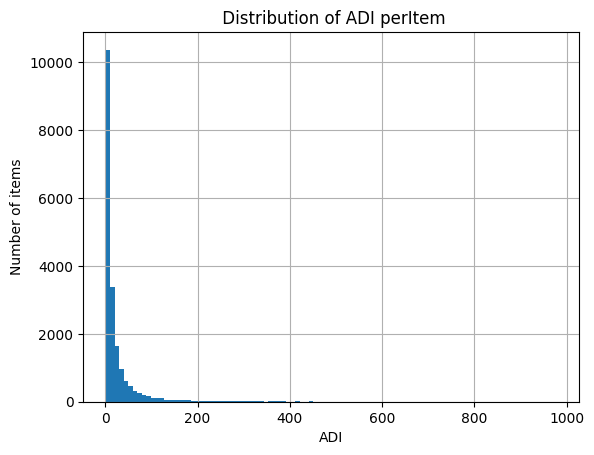

In [48]:
items_df['ADI'].hist(bins=100)
plt.xlabel('ADI')
plt.ylabel('Number of items')
plt.title(' Distribution of ADI perItem')
plt.show()


In [54]:
from src.notebooks.const import name_mapping

df_visual = filter_items[["ADI", "cv2", "zero_ratio"]].dropna().copy()


def label_demand(row, coe_adi=1.32, coe_cv2=0.49, coe_zero_ratio=0.6):
    # Nếu ADI cao hoặc zero_ratio lớn → Intermittent/Lumpy (Gián đoạn)
    if row["ADI"] > coe_adi or row["zero_ratio"] >= coe_zero_ratio:
        # Nếu CV² thấp → Intermittent (Gián đoạn & Ổn định)
        if row["cv2"] < coe_cv2:
            return 2  # Intermittent
        else:
            return 0  # Lumpy (Gián đoạn & Biến động)
    else:
        # Nếu ADI thấp và zero_ratio nhỏ → Smooth/Erratic (Thường xuyên)
        # Bất kể CV² cao hay thấp, trường hợp này đều được gán là Smooth
        return 1  # Smooth (Bao gồm cả Smooth và Erratic)


df_visual["demand_type"] = df_visual.apply(
    lambda x: label_demand(
        x,
        coe_adi=df_visual["ADI"].mean(),
        coe_cv2=df_visual["cv2"].mean(),
        coe_zero_ratio=df_visual["zero_ratio"].mean(),
    ),
    axis=1,
)

print(df_visual["demand_type"].value_counts())

print(df_visual[df_visual["demand_type"] == 2].head())
print(df_visual[df_visual["demand_type"] == 2].describe())
print(df_visual[df_visual["demand_type"] == 2].sample())

demand_type
2    12280
1     5864
0     1277
Name: count, dtype: int64
               ADI  cv2  zero_ratio  demand_type
item_id                                         
1.0      40.200000  0.0    0.994197            2
2.0      80.000000  0.0    0.998066            2
3.0      52.000000  0.0    0.998066            2
8.0       6.000000  0.0    0.998066            2
27.0     13.219512  0.0    0.959381            2
                ADI           cv2    zero_ratio  demand_type
count  12280.000000  12280.000000  12280.000000      12280.0
mean      38.231608      0.008735      0.975041          2.0
std       68.617450      0.021670      0.021201          0.0
min        1.000000      0.000000      0.923598          2.0
25%        9.104989      0.000000      0.959381          2.0
50%       17.183023      0.000000      0.981625          2.0
75%       37.578526      0.000000      0.993230          2.0
max      978.000000      0.115622      0.998066          2.0
           ADI  cv2  zero_ratio  dema

In [55]:
df_filtered = df[df['item_id'] == 1407.0]

26.773195472140596
0.11605218659261578
0.9235056530663281


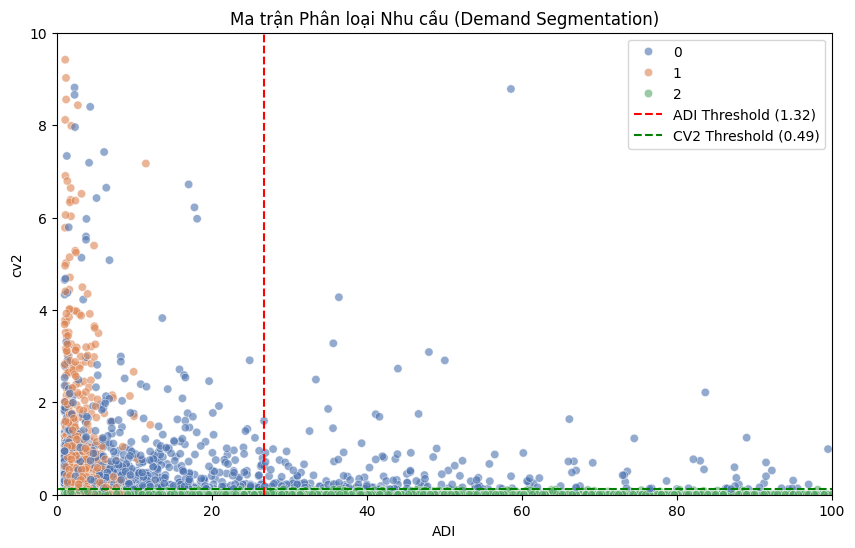

In [56]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_visual, x="ADI", y="cv2", hue="demand_type", alpha=0.6, palette="deep"
)

print(df_visual["ADI"].mean())
print(df_visual["cv2"].mean())
print(df_visual["zero_ratio"].mean())
plt.axvline(
    x=df_visual["ADI"].mean(),
    color="red",
    linestyle="--",
    label="ADI Threshold (1.32)",
)
# plt.axhline(
#     y=df_visual["cv2"].mean(),
#     color="green",
#     linestyle="--",
#     label="CV2 Threshold (0.49)",
# )
plt.axhline(
    y=df_visual["cv2"].mean(),
    color="green",
    linestyle="--",
    label="CV2 Threshold (0.49)",
)
plt.title("Ma trận Phân loại Nhu cầu (Demand Segmentation)")
plt.xlim(0, 100)
plt.ylim(0, 10)
plt.legend()
plt.show()

In [52]:
import plotly.express as px

df_visual["demand_type_name"] = df_visual["demand_type"].map(name_mapping)

# Vẽ 3D scatter Plotly
fig = px.scatter_3d(
    df_visual,
    x="ADI",
    y="cv2",
    z="zero_ratio",
    color="demand_type_name",  # dùng cột tên loại demand
    labels={
        "ADI": "ADI",
        "cv2": "CV²",
        "zero_ratio": "Zero Ratio",
        "demand_type_name": "Demand Type"
    },
    title="Interactive 3D Segmentation for Intermittent Demand"
)

# Không cần hover
fig.update_traces(hoverinfo="skip", hovertemplate=None)

# Marker nhỏ, trong suốt vừa phải
fig.update_traces(marker=dict(size=5, opacity=0.8))
fig.update_layout(legend_title_text="Demand Type")

fig.show()
